In [134]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from sklearn.metrics import explained_variance_score, \
    mean_absolute_error, \
    median_absolute_error
from sklearn.model_selection import train_test_split

In [135]:
np.random.seed(4747)

## Let's run through a basic analysis of one proxy Organism

#### Arctic Bay, Arctic: Coralline Algae (1967-2008)

In [136]:
raw_paleo_data = pd.read_csv("d18O_raw/ab_d18O_raw.csv")
raw_paleo_data.head()

,year,d18O
0,2008,-0.048160
1,2007,-0.045444
2,2006,-0.070624
3,2005,-0.095804
4,2004,0.027000


In [137]:
temp_data = pd.read_csv("temp_raw/ab_SODA_1x1_raw.csv")
temp_data.head(10)

,Unnamed: 0,time,lat,lon,depth,temp,salt
0,1,1967-01-15T00:00:00Z,72.75,273.75,5.01,-1.280347,31.575184
1,2,1967-01-15T00:00:00Z,72.75,274.25,5.01,-1.280931,31.576525
2,3,1967-01-15T00:00:00Z,73.25,273.75,5.01,-1.298791,31.579832
3,4,1967-01-15T00:00:00Z,73.25,274.25,5.01,-1.324163,31.503399
4,5,1967-01-15T00:00:00Z,73.75,273.75,5.01,-1.425924,30.357185
5,6,1967-01-15T00:00:00Z,73.75,274.25,5.01,-1.409098,30.414881
6,7,1967-02-15T00:00:00Z,72.75,273.75,5.01,-1.279240,31.829067
7,8,1967-02-15T00:00:00Z,72.75,274.25,5.01,-1.281839,31.826092
8,9,1967-02-15T00:00:00Z,73.25,273.75,5.01,-1.320389,31.776814
9,10,1967-02-15T00:00:00Z,73.25,274.25,5.01,-1.360575,31.597593


Let's make sure this temperature is averaged across the grid such that each month only has one temperature and one salinity value across the multiple lat/long pairs. 

In [138]:
monthly_temp_data = temp_data.groupby('time')

print(monthly_temp_data['temp'].agg(np.mean))

time
1967-01-15T00:00:00Z   -1.336542
1967-02-15T00:00:00Z   -1.343062
1967-03-15T00:00:00Z   -1.377000
1967-04-15T00:00:00Z   -1.455148
1967-05-15T00:00:00Z   -1.514044
                          ...   
2008-08-15T00:00:00Z   -0.197338
2008-09-15T00:00:00Z   -0.944179
2008-10-15T00:00:00Z   -1.022546
2008-11-15T00:00:00Z   -1.116120
2008-12-15T00:00:00Z   -1.164364
Name: temp, Length: 504, dtype: float64


Let's average these temperatures across years, across the grids. 

In [139]:
temp_data['year'] = temp_data['time'].apply(lambda x: x[0:4])
temp_data

,Unnamed: 0,time,lat,lon,depth,temp,salt,year
0,1,1967-01-15T00:00:00Z,72.75,273.75,5.01,-1.280347,31.575184,1967
1,2,1967-01-15T00:00:00Z,72.75,274.25,5.01,-1.280931,31.576525,1967
2,3,1967-01-15T00:00:00Z,73.25,273.75,5.01,-1.298791,31.579832,1967
3,4,1967-01-15T00:00:00Z,73.25,274.25,5.01,-1.324163,31.503399,1967
4,5,1967-01-15T00:00:00Z,73.75,273.75,5.01,-1.425924,30.357185,1967
...,...,...,...,...,...,...,...,...
3019,3020,2008-12-15T00:00:00Z,72.75,274.25,5.01,-1.109940,31.780386,2008
3020,3021,2008-12-15T00:00:00Z,73.25,273.75,5.01,-1.116151,31.646585,2008
3021,3022,2008-12-15T00:00:00Z,73.25,274.25,5.01,-1.128340,31.521568,2008
3022,3023,2008-12-15T00:00:00Z,73.75,273.75,5.01,-1.263921,30.873104,2008


Voila, now we have the average Sea Surface Temp for that lat/long grid on an annual basis:

In [140]:
actual_annual_temp = temp_data.groupby('year')['temp'].agg(np.mean).to_frame().reset_index()
# annual_temp['lat'] = 73.25
# annual_temp['long'] = 274.75

actual_annual_temp.head()

,year,temp
0,1967,-1.301917
1,1968,-0.175512
2,1969,-0.575391
3,1970,-1.314653
4,1971,-1.344812


Let's see how these two factors naturally correlate:

In [141]:
#pre-process for the merge

actual_annual_temp['year'] = actual_annual_temp['year'].apply(lambda x: int(x))

In [142]:
temp_and_algae = pd.merge(actual_annual_temp, raw_paleo_data, on='year')
temp_and_algae.set_index('year').head()

,temp,d18O
year,,
1967,-1.301917,-0.132046
1968,-0.175512,-0.134891
1969,-0.575391,-0.137737
1970,-1.314653,-0.134845
1971,-1.344812,-0.131952


In [143]:
import matplotlib.pyplot as plt


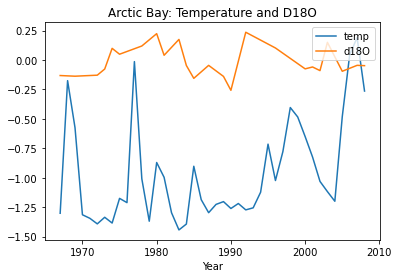

In [144]:
plt.plot(temp_and_algae['year'], temp_and_algae['temp'])
plt.plot(temp_and_algae['year'], temp_and_algae['d18O'])
plt.title('Arctic Bay: Temperature and D18O')
plt.xlabel('Year')
plt.legend(['temp', 'd18O'], loc='upper right')
plt.show()

We can see from the graph that there's some sort of relationships between the spikes in temp and d18O, but our correlation coefficient is rather underwhelming:

In [145]:
np.corrcoef(temp_and_algae['temp'], temp_and_algae['d18O'])

array([[ 1.        , -0.12974504],
       [-0.12974504,  1.        ]])

In [146]:
import statistics
statistics.variance(temp_and_algae['temp']), statistics.variance(temp_and_algae['d18O'])

(0.19341078570023343, 0.015289237992896332)

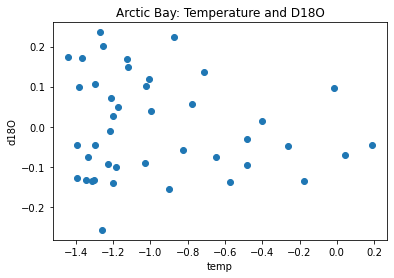

In [147]:
plt.scatter(temp_and_algae['temp'], temp_and_algae['d18O'])
plt.title('Arctic Bay: Temperature and D18O')
plt.xlabel('temp')
plt.ylabel('d18O')

# plt.legend(['temp', 'd18O'], loc='upper right')
plt.show()

Writing a function that can do this for any of the organisms on file:

In [148]:
def exploration(d18O_raw_filename, temp_raw_filename):
    paleo_data = pd.read_csv("d18O_raw/" + d18O_raw_filename)
    temp_data = pd.read_csv("temp_raw/" + temp_raw_filename)
    
#     print(paleo_data)
    
    temp_data['year'] = temp_data['time'].apply(lambda x: x[0:4])
    
#     print(temp_data)
    
    actual_annual_temp = temp_data.groupby('year')['temp'].agg(np.mean).to_frame().reset_index()
    actual_annual_temp['year'] = actual_annual_temp['year'].apply(lambda x: int(x))
    
    if d18O_raw_filename == 'amchitka_d18O_raw.csv':
        paleo_data['year'] = paleo_data['Year']
        paleo_data['d18O'] = paleo_data['AM-KR-80_d18O']
        del paleo_data['Year']
        del paleo_data['AM-KR-80_d18O']
    
    temp_and_algae = pd.merge(actual_annual_temp, paleo_data, on='year')
    temp_and_algae.set_index('year')
    
    print('pearson correlation:')
    print(np.corrcoef(temp_and_algae['temp'], temp_and_algae['d18O']))
    
    plt.plot(temp_and_algae['year'], temp_and_algae['temp'])
    plt.plot(temp_and_algae['year'], temp_and_algae['d18O'])
    plt.title(d18O_raw_filename.split("_")[0] +": Temperature and D18O")
    plt.xlabel('Year')
    plt.legend(['temp', 'd18O'], loc='upper right')
    plt.show()

pearson correlation:
[[ 1.         -0.27061659]
 [-0.27061659  1.        ]]


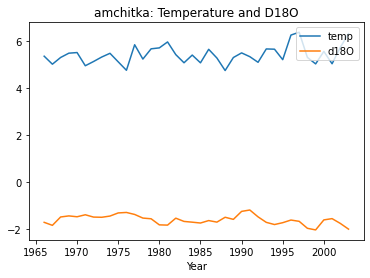

In [149]:
exploration('amchitka_d18O_raw.csv', 'amchitka_SODA_1x1_raw.csv')

pearson correlation:
[[ 1.         -0.42953347]
 [-0.42953347  1.        ]]


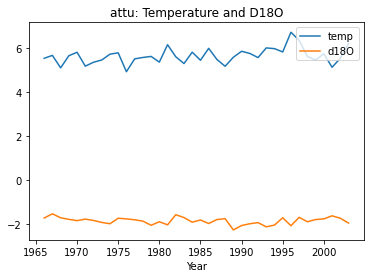

In [150]:
exploration('attu_d18O_raw.csv', 'attu_SODA_1x1_raw.csv')

pearson correlation:
[[ 1.         -0.00540379]
 [-0.00540379  1.        ]]


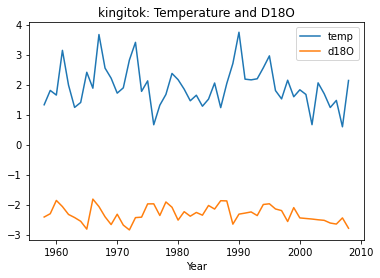

In [151]:
exploration('kingitok_d18O_raw.csv', 'Kingitok_SODA_1x1_raw.csv')

In [152]:
#exploration('maine_d18O_raw.csv', 'maine_SODA_1x1_raw.csv')

pearson correlation:
[[ 1.         -0.29826873]
 [-0.29826873  1.        ]]


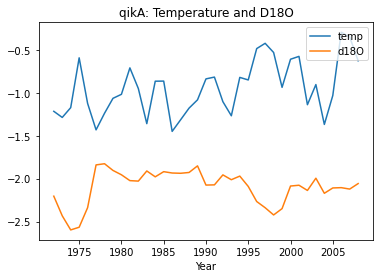

In [153]:
exploration('qikA_d18O_raw.csv', 'qikA_SODA_1x1_raw.csv')

pearson correlation:
[[ 1.         -0.34089223]
 [-0.34089223  1.        ]]


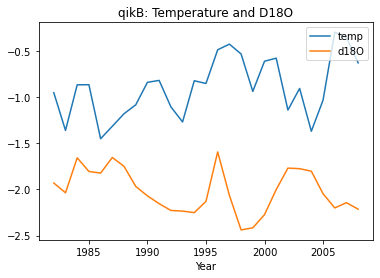

In [154]:
exploration('qikB_d18O_raw.csv', 'qikB_SODA_1x1_raw.csv')

In [155]:
algae_site_info = pd.read_csv("algae_site_info.csv")
algae_site_info

,site,lat,long,depth_meter
0,arctic_bay,73.25,274.75,5
1,amchitka,51.42,179.23,5
2,attu,52.78,173.17,5
3,kingitok,55.40,300.15,15
4,maine,44.13,291.75,10
5,qikA,67.56,295.98,5
6,qikB,67.56,295.98,5


By the way, here is where our sample locations are in the world. You can see that they're a bit crowded around the Northwest of the map below. 

In [156]:
import shapely
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

algae_site_info['long_formatted'] = algae_site_info['long'] - 360
algae_site_info

,site,lat,long,depth_meter,long_formatted
0,arctic_bay,73.25,274.75,5,-85.25
1,amchitka,51.42,179.23,5,-180.77
2,attu,52.78,173.17,5,-186.83
3,kingitok,55.40,300.15,15,-59.85
4,maine,44.13,291.75,10,-68.25
5,qikA,67.56,295.98,5,-64.02
6,qikB,67.56,295.98,5,-64.02


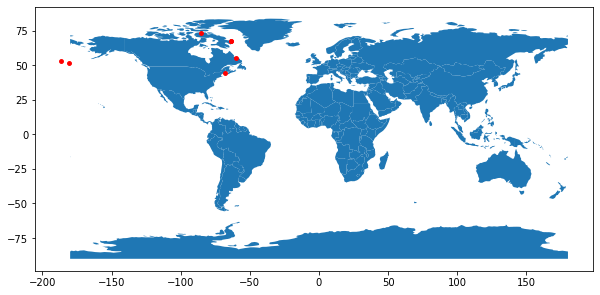

In [157]:
geometry = [Point(xy) for xy in zip(algae_site_info['long_formatted'], 
                                    algae_site_info['lat'])]

gdf = GeoDataFrame(algae_site_info, geometry=geometry)

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

## Introducing, Aspects of Machine Learning

In [158]:
temp_and_algae['lat'] = 73.25
temp_and_algae['long'] = 274.75
temp_and_algae = temp_and_algae.reset_index()
temp_and_algae.head()

,index,year,temp,d18O,lat,long
0,0,1967,-1.301917,-0.132046,73.25,274.75
1,1,1968,-0.175512,-0.134891,73.25,274.75
2,2,1969,-0.575391,-0.137737,73.25,274.75
3,3,1970,-1.314653,-0.134845,73.25,274.75
4,4,1971,-1.344812,-0.131952,73.25,274.75


As a proof of concept, let's build a little 'neural network' with all of our algae datasets. We want to predict `temp`, given `year`, `d18O`, `lat`, and `long`.

First, let's configure all the data into one big dataframe.

Then, let's scale everything between 1 and 0

In [159]:
paleo_df = ''
paleo_df

''

In [160]:
algae_files = [['ab_d18O_raw.csv', 73.25, 274.75, 5],
                ['amchitka_d18O_raw.csv', 51.42, 179.23, 5], 
                ['attu_d18O_raw.csv', 52.78, 173.17, 5],
                ['Kingitok_d18O_raw.csv', 55.4, 300.15, 15],
                #['maine_d18O_raw.csv',44.13,291.75,10],
                ['qikA_d18O_raw.csv', 67.56,295.98,5],
                ['qikB_d18O_raw.csv', 67.56,295.98,5]
               ]
                 
                 
temperature_files = [
    'ab_SODA_1x1_raw.csv', 
    'amchitka_SODA_1x1_raw.csv',
    'attu_SODA_1x1_raw.csv',
    'kingitok_SODA_1x1_raw.csv', 
    #'maine_SODA_1x1_raw.csv',
    'qikA_SODA_1x1_raw.csv', 
    'qikB_SODA_1x1_raw.csv']

In [161]:
paleo_df = ''
paleo_df = pd.DataFrame()

count = 0
for temperature_file in temperature_files:
    temp_data = pd.read_csv('temp_raw/' + temperature_file)
    print(temperature_file)
    # locate the year value
    temp_data['year'] = temp_data['time'].apply(lambda x: x[0:4])
    # group data annually
    actual_annual_temp = temp_data.groupby('year')['temp'].agg(np.mean).to_frame().reset_index()
    # convert year to an int type
    actual_annual_temp['year'] = actual_annual_temp['year'].apply(lambda x: int(x))
    
    algae_file = pd.read_csv('d18O_raw/' + algae_files[count][0])
    
    if algae_files[count][0] == "amchitka_d18O_raw.csv":
        algae_file = algae_file[['Year', 'AM-KR-80_d18O']]
        algae_file['d18O'] = algae_file['AM-KR-80_d18O']
        algae_file['year'] = algae_file['Year'].apply(lambda x: int(x))
        del algae_file['AM-KR-80_d18O']
        del algae_file['Year']
    
    elif algae_files[count][0] == "attu_d18O_raw.csv":
        algae_file = algae_file[['year', 'd18O']]
    else:
        algae_file['year'] = algae_file['year'].apply(lambda x: int(x))
    print(algae_files[count][0])
    
    
    temp_and_algae = pd.merge(actual_annual_temp, algae_file, on='year')
    #temp_and_algae = temp_and_algae.set_index('year').head()
    temp_and_algae['lat'] = algae_files[count][1]
    temp_and_algae['long'] = algae_files[count][2]
    temp_and_algae['depth'] = algae_files[count][3]
    temp_and_algae['location'] = temperature_file.split('_')[0]
    paleo_df = pd.concat([paleo_df, temp_and_algae], axis= 0)
    
    count += 1
    
paleo_df

ab_SODA_1x1_raw.csv
ab_d18O_raw.csv
amchitka_SODA_1x1_raw.csv
amchitka_d18O_raw.csv
attu_SODA_1x1_raw.csv
attu_d18O_raw.csv
kingitok_SODA_1x1_raw.csv
Kingitok_d18O_raw.csv
qikA_SODA_1x1_raw.csv
qikA_d18O_raw.csv
qikB_SODA_1x1_raw.csv
qikB_d18O_raw.csv


,year,temp,d18O,lat,long,depth,location
0,1967,-1.301917,-0.132046,73.25,274.75,5,ab
1,1968,-0.175512,-0.134891,73.25,274.75,5,ab
2,1969,-0.575391,-0.137737,73.25,274.75,5,ab
3,1970,-1.314653,-0.134845,73.25,274.75,5,ab
4,1971,-1.344812,-0.131952,73.25,274.75,5,ab
...,...,...,...,...,...,...,...
22,2004,-1.368374,-1.801891,67.56,295.98,5,qikB
23,2005,-1.031412,-2.045915,67.56,295.98,5,qikB
24,2006,-0.294162,-2.200304,67.56,295.98,5,qikB
25,2007,-0.349986,-2.143647,67.56,295.98,5,qikB


In [162]:
dataset = paleo_df.values
dataset

array([[1967, -1.3019167168272867, -0.13204552, ..., 274.75, 5, 'ab'],
       [1968, -0.1755116544922609, -0.13489132, ..., 274.75, 5, 'ab'],
       [1969, -0.5753912617866366, -0.13773713, ..., 274.75, 5, 'ab'],
       ...,
       [2006, -0.294161577132486, -2.200303795, ..., 295.98, 5, 'qikB'],
       [2007, -0.34998577832898486, -2.1436467009999998, ..., 295.98, 5,
        'qikB'],
       [2008, -0.6265848786348389, -2.214012989, ..., 295.98, 5, 'qikB']],
      dtype=object)

In [163]:
# dataset[row indices, column indices]
X =  dataset[:,(0,2,3,4,5)] # input
Y = dataset[:, 1] # output

In [164]:
X

array([[1967, -0.13204552, 73.25, 274.75, 5],
       [1968, -0.13489132, 73.25, 274.75, 5],
       [1969, -0.13773713, 73.25, 274.75, 5],
       ...,
       [2006, -2.200303795, 67.56, 295.98, 5],
       [2007, -2.1436467009999998, 67.56, 295.98, 5],
       [2008, -2.214012989, 67.56, 295.98, 5]], dtype=object)

In [165]:
Y

array([-1.3019167168272867, -0.1755116544922609, -0.5753912617866366,
       -1.3146528982453876, -1.3448122739791868, -1.3920445226960712,
       -1.3359799310565001, -1.3849985450506213, -1.1754808111323247,
       -1.211653700305356, -0.013779809801942856, -1.0094600215864684,
       -1.3693388253450396, -0.870893515991459, -0.9965212498274112,
       -1.2972207400533886, -1.4433993001778924, -1.3935131538245413,
       -0.9026492390936863, -1.186396862069766, -1.2970876296361284,
       -1.2265439720617402, -1.2031206612785652, -1.2614099631706877,
       -1.2190537187788226, -1.2732156051529773, -1.255806233319971,
       -1.1233683874209723, -0.7148553392520015, -1.0238563213497403,
       -0.7783196163363754, -0.403887448521952, -0.48413105389206756,
       -0.6506048443778936, -0.8245940825177562, -1.0313526487184896,
       -1.1179656643006537, -1.1998982553680737, -0.4817744810522229,
       0.044552326532235904, 0.18978038520112425, -0.2639748965512908,
       5.366422533988

In [166]:
from sklearn import preprocessing

In [167]:
min_max_scaler = preprocessing.MinMaxScaler()
X_scale = min_max_scaler.fit_transform(X)
X_scale

array([[0.18      , 0.88054431, 1.        , 0.7999685 , 0.        ],
       [0.2       , 0.87961982, 1.        , 0.7999685 , 0.        ],
       [0.22      , 0.87869532, 1.        , 0.7999685 , 0.        ],
       ...,
       [0.96      , 0.20864845, 0.73934952, 0.96716018, 0.        ],
       [0.98      , 0.22705412, 0.73934952, 0.96716018, 0.        ],
       [1.        , 0.20419487, 0.73934952, 0.96716018, 0.        ]])

In [168]:
from sklearn.model_selection import train_test_split

In [169]:
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(
    X_scale, Y, test_size=0.2)

In [170]:
X_train.shape

(186, 5)

In [171]:
X_val_and_test.shape

(47, 5)

In [172]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.advanced_activations import LeakyReLU

In [173]:
model = Sequential([
    Dense(32, activation=tf.keras.layers.LeakyReLU(alpha=0.2), input_shape=(5,), kernel_initializer='normal'),
    #kernel_initializer='normal'
#    Dense(32, activation='relu', input_shape=(5,)),
#      Dense(32, activation='relu'),
#      Dense(16, activation='relu'),
#      Dense(16, activation='relu'),
#      Dense(16, activation='relu'),
    Dense(1, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),
])

In [174]:
model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=[
        'MeanSquaredError',
    ]
)

In [175]:
# from sklearn.metrics import r2_score

# model.compile(optimizer='sgd',
#               loss='binary_crossentropy',
#               metrics=['r2_score'])

In [176]:
X_train = np.asarray(X_train).astype(np.float32)
Y_train = np.asarray(Y_train).astype(np.float32)
X_val_and_test = np.asarray(X_val_and_test).astype(np.float32)
Y_val_and_test = np.asarray(Y_val_and_test).astype(np.float32)

In [177]:
Y_val_and_test

array([ 5.736426  , -0.9363432 ,  5.7532063 , -0.5753717 , -0.7148553 ,
        5.7423973 ,  2.1378753 , -0.34998578,  3.7456834 ,  3.4085927 ,
       -0.95000595, -1.00946   ,  5.0255284 ,  5.3458576 ,  5.8511543 ,
        2.4115252 ,  6.714154  ,  2.560939  ,  3.1419713 , -0.8375872 ,
        1.8018566 , -0.70929044,  5.8541474 , -1.103164  ,  1.673075  ,
       -0.87089354,  5.570132  , -1.2031207 ,  4.755481  ,  1.2376771 ,
       -1.1233684 ,  2.1467083 , -1.3448123 ,  5.53125   , -0.01377981,
        1.5956877 ,  5.5070486 , -0.53001636,  6.2060294 ,  1.7163564 ,
        0.18978038,  5.6656775 ,  5.455052  ,  1.84829   ,  5.043736  ,
       -1.1863968 , -1.2674364 ], dtype=float32)

In [178]:
hist = model.fit(X_train, Y_train,
          batch_size=16, epochs=64,
          validation_data=(X_val_and_test, Y_val_and_test))

Epoch 1/64
12/12 [==============================] - 0s 10ms/step - loss: 10.8651 - mean_squared_error: 10.8651 - val_loss: 12.0388 - val_mean_squared_error: 12.0388
Epoch 2/64
12/12 [==============================] - 0s 2ms/step - loss: 10.5149 - mean_squared_error: 10.5149 - val_loss: 11.6091 - val_mean_squared_error: 11.6091
Epoch 3/64
12/12 [==============================] - 0s 3ms/step - loss: 10.1826 - mean_squared_error: 10.1826 - val_loss: 11.1804 - val_mean_squared_error: 11.1804
Epoch 4/64
12/12 [==============================] - 0s 3ms/step - loss: 9.8434 - mean_squared_error: 9.8434 - val_loss: 10.7271 - val_mean_squared_error: 10.7271
Epoch 5/64
12/12 [==============================] - 0s 3ms/step - loss: 9.4542 - mean_squared_error: 9.4542 - val_loss: 10.2356 - val_mean_squared_error: 10.2356
Epoch 6/64
12/12 [==============================] - 0s 3ms/step - loss: 9.0251 - mean_squared_error: 9.0251 - val_loss: 9.7106 - val_mean_squared_error: 9.7106
Epoch 7/64
12/12 [=====

Epoch 52/64
12/12 [==============================] - 0s 2ms/step - loss: 0.2627 - mean_squared_error: 0.2627 - val_loss: 0.4813 - val_mean_squared_error: 0.4813
Epoch 53/64
12/12 [==============================] - 0s 2ms/step - loss: 0.2572 - mean_squared_error: 0.2572 - val_loss: 0.4702 - val_mean_squared_error: 0.4702
Epoch 54/64
12/12 [==============================] - 0s 2ms/step - loss: 0.2521 - mean_squared_error: 0.2521 - val_loss: 0.4621 - val_mean_squared_error: 0.4621
Epoch 55/64
12/12 [==============================] - 0s 2ms/step - loss: 0.2488 - mean_squared_error: 0.2488 - val_loss: 0.4554 - val_mean_squared_error: 0.4554
Epoch 56/64
12/12 [==============================] - 0s 2ms/step - loss: 0.2452 - mean_squared_error: 0.2452 - val_loss: 0.4731 - val_mean_squared_error: 0.4731
Epoch 57/64
12/12 [==============================] - 0s 2ms/step - loss: 0.2412 - mean_squared_error: 0.2412 - val_loss: 0.4632 - val_mean_squared_error: 0.4632
Epoch 58/64
12/12 [===============

In [179]:
model.evaluate(X_val_and_test, Y_val_and_test)[1]

2/2 [==============================] - 0s 2ms/step - loss: 0.4427 - mean_squared_error: 0.4427


0.44266340136528015

This Sequential Neural Network Model produced an MSE of 0.4427.

In [103]:
import matplotlib.pyplot as plt

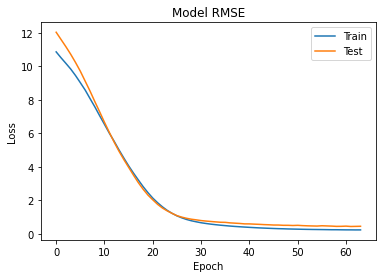

In [180]:
plt.plot(hist.history['mean_squared_error'])
plt.plot(hist.history['val_mean_squared_error'])
plt.title('Model RMSE')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Let's try to visualize this on a time series plot

In [887]:
# X_val_and_test

In [889]:
# Y_val_and_test

In [181]:
actual = pd.DataFrame(Y_val_and_test, columns=["actual"])
actual.head()

,actual
0,5.736426
1,-0.936343
2,5.753206
3,-0.575372
4,-0.714855


In [182]:
predicted = pd.DataFrame(model.predict(X_val_and_test), columns=["pred"])
predicted.head()

,pred
0,5.635177
1,-0.937195
2,5.373870
3,-0.902014
4,-0.860707


In [183]:
actual_v_pred = actual.join(predicted, how = "inner")
#actual_v_pred['pred_altered'] = actual_v_pred['pred'].apply(lambda x: (((x-1)/2)**2)*5)
actual_v_pred.head()

,actual,pred
0,5.736426,5.635177
1,-0.936343,-0.937195
2,5.753206,5.373870
3,-0.575372,-0.902014
4,-0.714855,-0.860707


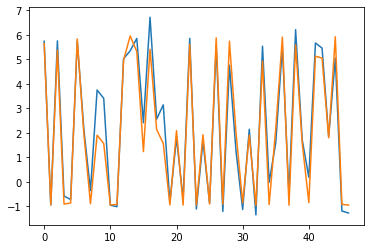

In [184]:
plt.plot(actual_v_pred)

In [185]:
import numpy as np
np.corrcoef(actual_v_pred['actual'], actual_v_pred['pred'])

array([[1.       , 0.9734566],
       [0.9734566, 1.       ]])

In [186]:
from scipy.stats import pearsonr

pearsonr(actual_v_pred['actual'], actual_v_pred['pred'])

(0.9734566033813612, 1.843898588292523e-30)

This says that the two variables have a correlation of 0.97 and a p-value of basically 0. 

In [187]:
model.evaluate(X_train, Y_train), mean_squared_error(actual_v_pred['actual'], actual_v_pred['pred'])

6/6 [==============================] - 0s 1ms/step - loss: 0.2202 - mean_squared_error: 0.2202


([0.22024847567081451, 0.22024847567081451], 0.4426634)

### Let's try a 'regular' multiple linear regression model:

In [188]:
from sklearn.linear_model import LinearRegression

In [189]:
model = LinearRegression()
model.fit(X_train, Y_train)
preds_linear = pd.DataFrame(model.predict(X_val_and_test), columns=["pred"])
#print("Loss: " + str(loss(rounded_preds, test_labels)))

In [190]:
actual_v_pred_linear = actual.join(preds_linear, how = "inner")
actual_v_pred_linear['diff'] = actual_v_pred_linear['actual'] - actual_v_pred_linear['pred']
actual_v_pred_linear.head()

,actual,pred,diff
0,5.736426,5.698994,0.037432
1,-0.936343,-0.812579,-0.123764
2,5.753206,5.698608,0.054598
3,-0.575372,-0.869005,0.293634
4,-0.714855,-1.001359,0.286504


In [191]:
from sklearn.metrics import mean_squared_error
model.score(X_train, Y_train), mean_squared_error(Y_val_and_test, preds_linear)

(0.9796442749598053, 0.33060735)

Here we see that the LinearRegression model produced a `score` of 0.979 and a MSE of 0.33.

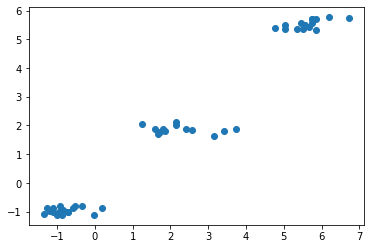

In [192]:
plt.scatter(actual_v_pred_linear['actual'], actual_v_pred_linear['pred'])

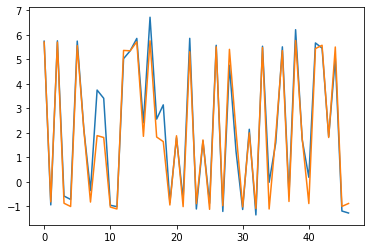

In [193]:
plt.plot(actual_v_pred_linear['actual'])
plt.plot(actual_v_pred_linear['pred'])

WOw, the predicted are so similar to the actual that you cannot discern between the two.

In [194]:
print('Intercept: \n', model.intercept_)
print('Coefficients: \n', model.coef_)

Intercept: 
 5.82712
Coefficients: 
 [ 0.3110296 -0.7779452 -1.8181679 -5.610072   1.9364651]


If we assign the coefficients to their respective input features (`year`, `d18O`, `lat`, `long`, `depth`) it is weird to observe that latitude, longitude, and depth had the 'largest' impact on the output `temp` variable -- far more than `d18O`!

Looking at this is one of the many benefits of using a LinReg Model, we are able to see what the model finds important (versus a NN where a lot is hidden).

<!-- Perhaps as expected, the model was able to discern that the d18O was the most important factor in determining the predicted temperature. This is seen by the second coefficient in the model (relating to d18O) being the largest number. It appears as tho the other coefficients (relating to year, lat, long, and depth) are extraordinarily tiny comparatively. -->

In [195]:
paleo_df

,year,temp,d18O,lat,long,depth,location
0,1967,-1.301917,-0.132046,73.25,274.75,5,ab
1,1968,-0.175512,-0.134891,73.25,274.75,5,ab
2,1969,-0.575391,-0.137737,73.25,274.75,5,ab
3,1970,-1.314653,-0.134845,73.25,274.75,5,ab
4,1971,-1.344812,-0.131952,73.25,274.75,5,ab
...,...,...,...,...,...,...,...
22,2004,-1.368374,-1.801891,67.56,295.98,5,qikB
23,2005,-1.031412,-2.045915,67.56,295.98,5,qikB
24,2006,-0.294162,-2.200304,67.56,295.98,5,qikB
25,2007,-0.349986,-2.143647,67.56,295.98,5,qikB


## Sequential Neural Network

Okay.. so linear regression seemed to do the trick for these organisms really damn well. Let's see if we can recreate this with a Sequential Neural Network (aka: a sequence of linear combinations as a result of matrix operations). We will be using the ReLU activation function ( a linear function )

In [196]:
network = Sequential()
network.add(Dense(8, input_shape=(5,), activation='LeakyReLU'))
network.add(Dense(6, activation='LeakyReLU'))
network.add(Dense(6, activation='LeakyReLU'))
network.add(Dense(4, activation='LeakyReLU'))
network.add(Dense(1, activation='LeakyReLU'))

network.compile('adam', loss='mse', metrics=['mse'])
network.fit(X_train, Y_train, epochs=1000)

Epoch 1/1000
6/6 [==============================] - 0s 1ms/step - loss: 11.0279 - mse: 11.0279
Epoch 2/1000
6/6 [==============================] - 0s 1ms/step - loss: 10.9302 - mse: 10.9302
Epoch 3/1000
6/6 [==============================] - 0s 1ms/step - loss: 10.8130 - mse: 10.8130
Epoch 4/1000
6/6 [==============================] - 0s 1ms/step - loss: 10.6833 - mse: 10.6833
Epoch 5/1000
6/6 [==============================] - 0s 1ms/step - loss: 10.5486 - mse: 10.5486
Epoch 6/1000
6/6 [==============================] - 0s 1ms/step - loss: 10.3828 - mse: 10.3828
Epoch 7/1000
6/6 [==============================] - 0s 1ms/step - loss: 10.1895 - mse: 10.1895
Epoch 8/1000
6/6 [==============================] - 0s 2ms/step - loss: 9.9919 - mse: 9.9919
Epoch 9/1000
6/6 [==============================] - 0s 1ms/step - loss: 9.7634 - mse: 9.7634
Epoch 10/1000
6/6 [==============================] - 0s 2ms/step - loss: 9.5325 - mse: 9.5325
Epoch 11/1000
6/6 [==============================] - 0s

Epoch 88/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1896 - mse: 0.1896
Epoch 89/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1895 - mse: 0.1895
Epoch 90/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1886 - mse: 0.1886
Epoch 91/1000
6/6 [==============================] - 0s 944us/step - loss: 0.1898 - mse: 0.1898
Epoch 92/1000
6/6 [==============================] - 0s 974us/step - loss: 0.1882 - mse: 0.1882
Epoch 93/1000
6/6 [==============================] - 0s 1000us/step - loss: 0.1892 - mse: 0.1892
Epoch 94/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1872 - mse: 0.1872
Epoch 95/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1872 - mse: 0.1872
Epoch 96/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1870 - mse: 0.1870
Epoch 97/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1867 - mse: 0.1867
Epoch 98/1000
6/6 [==============================] - 

6/6 [==============================] - 0s 1ms/step - loss: 0.1794 - mse: 0.1794
Epoch 175/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1815 - mse: 0.1815
Epoch 176/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1796 - mse: 0.1796
Epoch 177/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1793 - mse: 0.1793
Epoch 178/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1797 - mse: 0.1797
Epoch 179/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1792 - mse: 0.1792
Epoch 180/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1789 - mse: 0.1789
Epoch 181/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1794 - mse: 0.1794
Epoch 182/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1787 - mse: 0.1787
Epoch 183/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1798 - mse: 0.1798
Epoch 184/1000
6/6 [==============================] - 0s 1ms/step

6/6 [==============================] - 0s 1ms/step - loss: 0.1749 - mse: 0.1749
Epoch 261/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1751 - mse: 0.1751
Epoch 262/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1751 - mse: 0.1751
Epoch 263/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1750 - mse: 0.1750
Epoch 264/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1750 - mse: 0.1750
Epoch 265/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1747 - mse: 0.1747
Epoch 266/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1763 - mse: 0.1763
Epoch 267/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1751 - mse: 0.1751
Epoch 268/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1745 - mse: 0.1745
Epoch 269/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1751 - mse: 0.1751
Epoch 270/1000
6/6 [==============================] - 0s 1ms/step

6/6 [==============================] - 0s 1ms/step - loss: 0.1726 - mse: 0.1726
Epoch 347/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1741 - mse: 0.1741
Epoch 348/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1725 - mse: 0.1725
Epoch 349/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1709 - mse: 0.1709
Epoch 350/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1742 - mse: 0.1742
Epoch 351/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1729 - mse: 0.1729
Epoch 352/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1720 - mse: 0.1720
Epoch 353/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1736 - mse: 0.1736
Epoch 354/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1721 - mse: 0.1721
Epoch 355/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1729 - mse: 0.1729
Epoch 356/1000
6/6 [==============================] - 0s 1ms/step

6/6 [==============================] - 0s 1ms/step - loss: 0.1706 - mse: 0.1706
Epoch 433/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1699 - mse: 0.1699
Epoch 434/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1705 - mse: 0.1705
Epoch 435/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1715 - mse: 0.1715
Epoch 436/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1714 - mse: 0.1714
Epoch 437/1000
6/6 [==============================] - 0s 992us/step - loss: 0.1707 - mse: 0.1707
Epoch 438/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1714 - mse: 0.1714
Epoch 439/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1704 - mse: 0.1704
Epoch 440/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1708 - mse: 0.1708
Epoch 441/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1725 - mse: 0.1725
Epoch 442/1000
6/6 [==============================] - 0s 1ms/st

6/6 [==============================] - 0s 1ms/step - loss: 0.1674 - mse: 0.1674
Epoch 519/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1684 - mse: 0.1684
Epoch 520/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1679 - mse: 0.1679
Epoch 521/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1688 - mse: 0.1688
Epoch 522/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1676 - mse: 0.1676
Epoch 523/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1676 - mse: 0.1676
Epoch 524/1000
6/6 [==============================] - 0s 963us/step - loss: 0.1706 - mse: 0.1706
Epoch 525/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1675 - mse: 0.1675
Epoch 526/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1676 - mse: 0.1676
Epoch 527/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1694 - mse: 0.1694
Epoch 528/1000
6/6 [==============================] - 0s 1ms/st

6/6 [==============================] - 0s 1ms/step - loss: 0.1670 - mse: 0.1670
Epoch 605/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1668 - mse: 0.1668
Epoch 606/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1697 - mse: 0.1697
Epoch 607/1000
6/6 [==============================] - 0s 977us/step - loss: 0.1655 - mse: 0.1655
Epoch 608/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1691 - mse: 0.1691
Epoch 609/1000
6/6 [==============================] - 0s 997us/step - loss: 0.1662 - mse: 0.1662
Epoch 610/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1687 - mse: 0.1687
Epoch 611/1000
6/6 [==============================] - 0s 989us/step - loss: 0.1682 - mse: 0.1682
Epoch 612/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1675 - mse: 0.1675
Epoch 613/1000
6/6 [==============================] - 0s 938us/step - loss: 0.1648 - mse: 0.1648
Epoch 614/1000
6/6 [==============================] - 0s 

6/6 [==============================] - 0s 1ms/step - loss: 0.1635 - mse: 0.1635
Epoch 690/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1633 - mse: 0.1633
Epoch 691/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1638 - mse: 0.1638
Epoch 692/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1636 - mse: 0.1636
Epoch 693/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1644 - mse: 0.1644
Epoch 694/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1665 - mse: 0.1665
Epoch 695/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1642 - mse: 0.1642
Epoch 696/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1642 - mse: 0.1642
Epoch 697/1000
6/6 [==============================] - 0s 951us/step - loss: 0.1638 - mse: 0.1638
Epoch 698/1000
6/6 [==============================] - 0s 909us/step - loss: 0.1637 - mse: 0.1637
Epoch 699/1000
6/6 [==============================] - 0s 911u

6/6 [==============================] - 0s 980us/step - loss: 0.1629 - mse: 0.1629
Epoch 776/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1633 - mse: 0.1633
Epoch 777/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1635 - mse: 0.1635
Epoch 778/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1605 - mse: 0.1605
Epoch 779/1000
6/6 [==============================] - 0s 945us/step - loss: 0.1629 - mse: 0.1629
Epoch 780/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1624 - mse: 0.1624
Epoch 781/1000
6/6 [==============================] - 0s 920us/step - loss: 0.1619 - mse: 0.1619
Epoch 782/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1618 - mse: 0.1618
Epoch 783/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1612 - mse: 0.1612
Epoch 784/1000
6/6 [==============================] - 0s 995us/step - loss: 0.1617 - mse: 0.1617
Epoch 785/1000
6/6 [==============================] - 0s 

6/6 [==============================] - 0s 968us/step - loss: 0.1622 - mse: 0.1622
Epoch 861/1000
6/6 [==============================] - 0s 991us/step - loss: 0.1591 - mse: 0.1591
Epoch 862/1000
6/6 [==============================] - 0s 942us/step - loss: 0.1597 - mse: 0.1597
Epoch 863/1000
6/6 [==============================] - 0s 977us/step - loss: 0.1593 - mse: 0.1593
Epoch 864/1000
6/6 [==============================] - 0s 909us/step - loss: 0.1590 - mse: 0.1590
Epoch 865/1000
6/6 [==============================] - 0s 944us/step - loss: 0.1602 - mse: 0.1602
Epoch 866/1000
6/6 [==============================] - 0s 879us/step - loss: 0.1598 - mse: 0.1598
Epoch 867/1000
6/6 [==============================] - 0s 959us/step - loss: 0.1592 - mse: 0.1592
Epoch 868/1000
6/6 [==============================] - 0s 911us/step - loss: 0.1590 - mse: 0.1590
Epoch 869/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.1596 - mse: 0.1596
Epoch 870/1000
6/6 [===========================

6/6 [==============================] - 0s 891us/step - loss: 0.1559 - mse: 0.1559
Epoch 945/1000
6/6 [==============================] - 0s 906us/step - loss: 0.1584 - mse: 0.1584
Epoch 946/1000
6/6 [==============================] - 0s 880us/step - loss: 0.1565 - mse: 0.1565
Epoch 947/1000
6/6 [==============================] - 0s 924us/step - loss: 0.1568 - mse: 0.1568
Epoch 948/1000
6/6 [==============================] - 0s 890us/step - loss: 0.1565 - mse: 0.1565
Epoch 949/1000
6/6 [==============================] - 0s 924us/step - loss: 0.1611 - mse: 0.1611
Epoch 950/1000
6/6 [==============================] - 0s 925us/step - loss: 0.1547 - mse: 0.1547
Epoch 951/1000
6/6 [==============================] - 0s 976us/step - loss: 0.1614 - mse: 0.1614
Epoch 952/1000
6/6 [==============================] - 0s 963us/step - loss: 0.1566 - mse: 0.1566
Epoch 953/1000
6/6 [==============================] - 0s 911us/step - loss: 0.1598 - mse: 0.1598
Epoch 954/1000
6/6 [=========================

In [197]:
predicted = pd.DataFrame(network.predict(X_val_and_test), columns=["pred"])
predicted.head()

,pred
0,5.697541
1,-0.931081
2,5.709077
3,-0.929255
4,-0.951365


In [198]:
actual_v_pred = actual.join(predicted, how = "inner")
actual_v_pred.head()

,actual,pred
0,5.736426,5.697541
1,-0.936343,-0.931081
2,5.753206,5.709077
3,-0.575372,-0.929255
4,-0.714855,-0.951365


In [199]:
mean_squared_error(Y_val_and_test, predicted)

0.31270435

This slighlty different (more hidden layers, more epochs) NN produced a MSE of 0.313 -- which is marginally better than the Linear Regression model above (0.33), and much better than the first Sequential NN Model which only had 1 layer (0.44). 

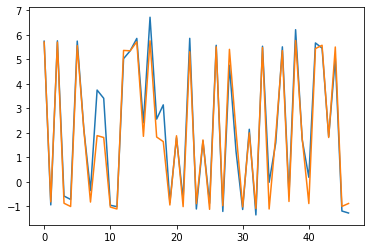

In [202]:
plt.plot(actual_v_pred_linear['actual']) # blue
plt.plot(actual_v_pred_linear['pred']) # orange